<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/beans_classification_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz


--2023-10-03 18:11:45--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.94.4, 3.5.29.59, 3.5.25.237, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.94.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179790562 (171M) [application/x-gzip]
Saving to: ‘beans_dataset.tar.gz’

beans_dataset.tar.g 100%[===================>] 171.46M  40.8MB/s    in 4.4s    

2023-10-03 18:11:50 (39.4 MB/s) - ‘beans_dataset.tar.gz’ saved [179790562/179790562]



In [3]:
import tarfile

In [4]:
with tarfile.open('beans_dataset.tar.gz') as tar:
    tar.extractall(path='data/')

In [5]:
# load the datasets
train = tf.keras.utils.image_dataset_from_directory('/content/data/beans/train')
val = tf.keras.utils.image_dataset_from_directory('/content/data/beans/validation')
test = tf.keras.utils.image_dataset_from_directory('/content/data/beans/test')



Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [6]:
example = train.take(1)

In [7]:
for x, y in train.take(1):
    print(x.shape, y.shape)

(32, 256, 256, 3) (32,)


1


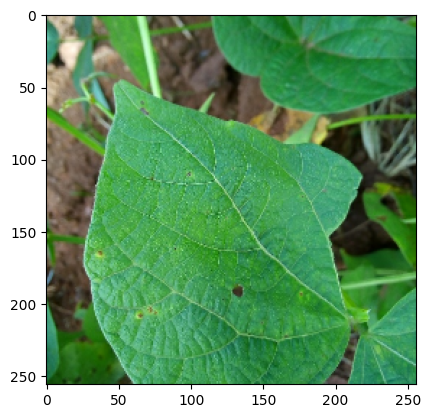

In [8]:
img = x[7]
img = img/255.0
print(y[7].numpy())
plt.imshow(img)



In [17]:
IMG_SIZE = 224

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = image/255.0
    label = tf.one_hot(label, 3)
    return image, label


In [18]:
augnment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.2)
])

In [19]:
train_ds = train.map(preprocess).cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val.map(preprocess).cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.map(preprocess).cache().shuffle(10)


#EfficientNetB0

In [49]:
# create model using EfficientNetB0

def create_model(lr = 0.008) -> tf.keras.Model:
  base_model = tf.keras.applications.EfficientNetB0(
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
      weights='imagenet',
      include_top=False)
  base_model.trainable = False

  model = tf.keras.Sequential([
      augnment,
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(3, activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [50]:
model = create_model()

In [51]:
MC = tf.keras.callbacks.ModelCheckpoint(
    'model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose =0)
history = model.fit(train_ds, validation_data=val_ds, epochs=60, callbacks = [MC])


Epoch 1/60
32/33 [============================>.] - ETA: 0s - loss: 0.7112 - accuracy: 0.6836

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 11s 94ms/step - loss: 0.7041 - accuracy: 0.6867 - val_loss: 0.5332 - val_accuracy: 0.8045
Epoch 2/60
33/33 [==============================] - 1s 45ms/step - loss: 0.4219 - accuracy: 0.8385 - val_loss: 0.4268 - val_accuracy: 0.8271
Epoch 3/60
33/33 [==============================] - 2s 52ms/step - loss: 0.3350 - accuracy: 0.8665 - val_loss: 0.2991 - val_accuracy: 0.8797
Epoch 4/60
33/33 [==============================] - 1s 37ms/step - loss: 0.3174 - accuracy: 0.8752 - val_loss: 0.4192 - val_accuracy: 0.8421
Epoch 5/60
33/33 [==============================] - 1s 35ms/step - loss: 0.2908 - accuracy: 0.8839 - val_loss: 0.4754 - val_accuracy: 0.8421
Epoch 6/60
33/33 [==============================] - 1s 35ms/step - loss: 0.2784 - accuracy: 0.8868 - val_loss: 0.2760 - val_accuracy: 0.8722
Epoch 7/60
33/33 [==============================] - 1s 44ms/step - loss: 0.2519 - accuracy: 0.9043 - val_loss: 0.2321 - val_accuracy: 0.8947
Epoch 8/60
33/33 [=====

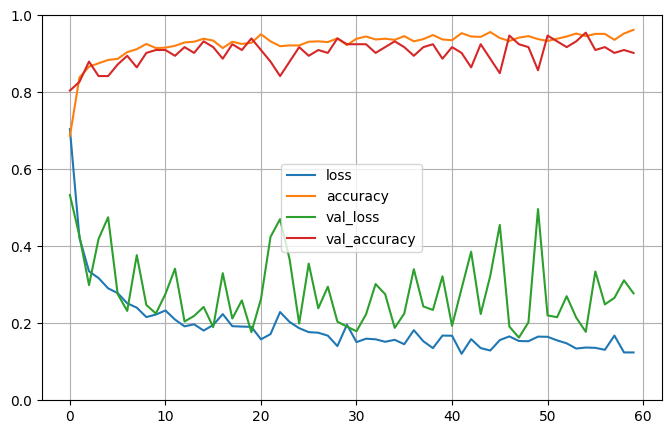

In [52]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()



In [53]:
model = tf.keras.models.load_model('model.h5')

In [54]:
model.evaluate(test_ds)


4/4 [==============================] - 2s 36ms/step - loss: 0.2613 - accuracy: 0.9141


[0.26128920912742615, 0.9140625]

In [55]:
model.evaluate(val_ds)

5/5 [==============================] - 0s 31ms/step - loss: 0.1777 - accuracy: 0.9549


[0.1777312457561493, 0.9548872113227844]

## train the 3 latest layers

In [110]:
from itertools import filterfalse
def ef_net_modification(lr = 0.001) -> tf.keras.Model:
  input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = augnment(input)

  base_model = tf.keras.applications.EfficientNetB0(
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
      weights='imagenet',
      include_top=False)

  for layer in base_model.layers[:-3]:
    layer.trainable = False
  x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
  model = tf.keras.Model(input, outputs)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [111]:
model2 = ef_net_modification(lr = 0.001)

In [112]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_17 (Dense)            (None, 3)                 3843      
                                                                 
Total params: 4053414 (15.46 MB)
Trainable params: 416003 (

In [113]:
MC = tf.keras.callbacks.ModelCheckpoint(
    'model2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose =0)
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=60, callbacks = [MC])

Epoch 1/60
33/33 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7524

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 11s 94ms/step - loss: 0.6053 - accuracy: 0.7524 - val_loss: 0.4081 - val_accuracy: 0.8271
Epoch 2/60
33/33 [==============================] - 2s 46ms/step - loss: 0.3532 - accuracy: 0.8733 - val_loss: 0.3390 - val_accuracy: 0.8496
Epoch 3/60
33/33 [==============================] - 1s 36ms/step - loss: 0.2860 - accuracy: 0.9052 - val_loss: 0.3531 - val_accuracy: 0.8421
Epoch 4/60
33/33 [==============================] - 2s 46ms/step - loss: 0.2405 - accuracy: 0.9226 - val_loss: 0.3431 - val_accuracy: 0.8647
Epoch 5/60
33/33 [==============================] - 1s 38ms/step - loss: 0.2185 - accuracy: 0.9236 - val_loss: 0.4523 - val_accuracy: 0.8346
Epoch 6/60
33/33 [==============================] - 1s 42ms/step - loss: 0.1904 - accuracy: 0.9342 - val_loss: 0.4738 - val_accuracy: 0.8346
Epoch 7/60
33/33 [==============================] - 2s 47ms/step - loss: 0.1656 - accuracy: 0.9381 - val_loss: 0.2395 - val_accuracy: 0.9023
Epoch 8/60
33/33 [=====

In [101]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_8  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 4053414 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [115]:
model2 = tf.keras.models.load_model('model2.h5')


In [116]:
model2.evaluate(test_ds)


4/4 [==============================] - 2s 34ms/step - loss: 0.1797 - accuracy: 0.9219


[0.17965497076511383, 0.921875]

In [117]:
model2.evaluate(val_ds)

5/5 [==============================] - 0s 33ms/step - loss: 0.0918 - accuracy: 0.9699


[0.09175977855920792, 0.969924807548523]

# VGG-19 model

In [132]:
def create_vgg19_model(lr = 0.008) -> tf.keras.Model:
  base_model = tf.keras.applications.vgg19.VGG19(
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
      weights='imagenet',
      include_top=False)
  for layer in base_model.layers[:-2]:
    layer.trainable = False
  inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = augnment(inputs)
  x = tf.keras.applications.vgg19.preprocess_input(x)
  x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x )
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x )
  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [133]:
vgg19 = create_vgg19_model()


In [134]:
vgg19.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0   

In [135]:
MC = tf.keras.callbacks.ModelCheckpoint(
    'vgg19_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose =0)
history_vgg16 = vgg19.fit(train_ds, validation_data=val_ds, epochs=60, callbacks = [MC])

Epoch 1/60
33/33 [==============================] - 7s 79ms/step - loss: 39.9399 - accuracy: 0.5406 - val_loss: 0.6884 - val_accuracy: 0.6391
Epoch 2/60
33/33 [==============================] - 2s 71ms/step - loss: 0.7037 - accuracy: 0.6905 - val_loss: 0.5184 - val_accuracy: 0.7895
Epoch 3/60
33/33 [==============================] - 2s 72ms/step - loss: 0.5735 - accuracy: 0.7466 - val_loss: 0.3849 - val_accuracy: 0.8421
Epoch 4/60
33/33 [==============================] - 2s 64ms/step - loss: 0.5706 - accuracy: 0.7882 - val_loss: 0.4171 - val_accuracy: 0.8271
Epoch 5/60
33/33 [==============================] - 2s 76ms/step - loss: 0.3904 - accuracy: 0.8443 - val_loss: 0.2465 - val_accuracy: 0.8947
Epoch 6/60
33/33 [==============================] - 2s 64ms/step - loss: 0.3405 - accuracy: 0.8762 - val_loss: 0.5237 - val_accuracy: 0.8571
Epoch 7/60
33/33 [==============================] - 2s 63ms/step - loss: 0.3979 - accuracy: 0.8627 - val_loss: 0.2824 - val_accuracy: 0.8722
Epoch 8/60
3

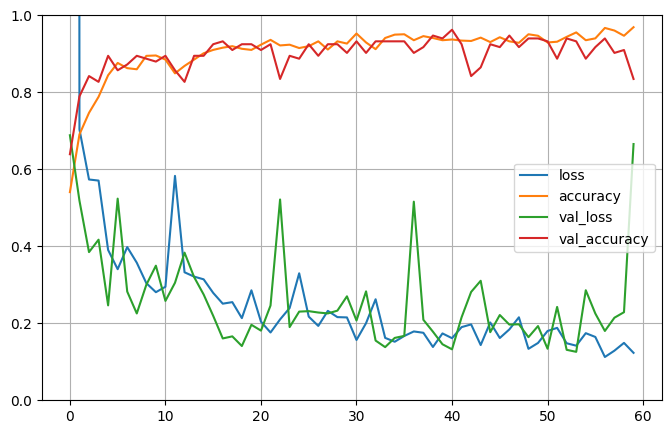

In [136]:
pd.DataFrame(history_vgg19.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [137]:
vgg19 = tf.keras.models.load_model('vgg16_model.h5')


In [138]:
vgg19.evaluate(test_ds)

4/4 [==============================] - 1s 58ms/step - loss: 0.2328 - accuracy: 0.9453


[0.23284275829792023, 0.9453125]

In [139]:
vgg19.evaluate(val_ds)

5/5 [==============================] - 0s 54ms/step - loss: 0.1323 - accuracy: 0.9624


[0.13229359686374664, 0.9624060392379761]